In [1]:
import torch

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
device = torch.device(device)
print(device)

cuda


NLP generate dynamic cues

In [ ]:
from sentence_transformers import SentenceTransformer, util
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration


processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
semantic_model = SentenceTransformer("all-MiniLM-L6-v2")


image = Image.open("E:\CCS3\dataset\Image 10.jpg")

inputs = processor(images=image, return_tensors="pt")
outputs = model.generate(
    **inputs,
    num_beams=5,  
    num_return_sequences=5,  
    max_length=20
)

candidate_descriptions = [processor.decode(output, skip_special_tokens=True) for output in outputs]

target_description = "A 4-people happy family "       # The description we want to find similar candidates for

target_embedding = semantic_model.encode(target_description, convert_to_tensor=True)
candidate_embeddings = semantic_model.encode(candidate_descriptions, convert_to_tensor=True)
similarities = util.pytorch_cos_sim(target_embedding, candidate_embeddings)

best_index = similarities.argmax().item()
best_description = candidate_descriptions[best_index]

print(f"Best Description: {best_description}")
print(f"Candidate Descriptions: {candidate_descriptions}")


EyeGesture application and generate csv file

In [ ]:
import cv2
import csv
import time
from eyeGestures.utils import VideoCapture
from eyeGestures import EyeGestures_v2
import os

# Initialize gesture engine and video capture
gestures = EyeGestures_v2()
cap = VideoCapture(0)
calibrate = True 

# Experiment parameters
screen_width = 1920  # Full HD screen width
screen_height = 1080  # Full HD screen height
middle_buffer = 100  # Middle region buffer to avoid ambiguity
total_groups = 6  # Total number of groups
pre_detection_duration = 2  # First 2 seconds without detection
detection_duration = 9  # Next 9 seconds for detection
csv_file = "experiment_data.csv"

# Check if the CSV file exists
if os.path.exists(csv_file):
    with open(csv_file, mode='r', newline='') as file:
        reader = csv.DictReader(file)
        existing_data = list(reader)
        if existing_data:
            last_participant_id = int(existing_data[-1]["Participant"])
        else:
            last_participant_id = 0
else:
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Participant", "Group", "Condition", "First_Fixation", "Positive_Time", "Negative_Time"])
    last_participant_id = 0


participant_id = last_participant_id + 1

for group in range(1, total_groups + 1):
    print(f"Starting Group {group} for Participant {participant_id}")

    positive_time = 0
    negative_time = 0
    first_fixation = None
    first_fixation_recorded = False
    time_in_current_area = 0
    current_area = None  

    pre_detection_start = time.time()
    while time.time() - pre_detection_start < pre_detection_duration:
        ret, frame = cap.read()
        if not ret:
            print("Failed to capture frame.")
            break

        cv2.putText(frame, "Focus on the left or right image", (50, 50), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        cv2.imshow("Eye Tracking", frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            print("Exiting program manually.")
            break

    print(f"Group {group}: Starting gaze detection.")
    detection_start = time.time()
    while time.time() - detection_start < detection_duration:
        ret, frame = cap.read()
        if not ret:
            print("Failed to capture frame.")
            break

        event, cevent = gestures.step(frame, calibrate, screen_width, screen_height, context="my_context")

        if event:
            cursor_x, cursor_y = event.point[0], event.point[1]
            fixation = event.fixation

            if cursor_x < screen_width / 2 - middle_buffer:
                if current_area != "Positive":
                    current_area = "Positive"
                    time_in_current_area = 0  
                time_in_current_area += 1 / 30.0  

                if not first_fixation_recorded:
                    first_fixation = "Positive"
                    first_fixation_recorded = True
                positive_time += 1 / 30.0

            elif cursor_x > screen_width / 2 + middle_buffer:
                if current_area != "Negative":
                    current_area = "Negative"
                    time_in_current_area = 0 
                time_in_current_area += 1 / 30.0

                if not first_fixation_recorded:
                    first_fixation = "Negative"
                    first_fixation_recorded = True
                negative_time += 1 / 30.0

            else:
                current_area = None

        cv2.imshow("Eye Tracking", frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            print("Exiting program manually.")
            break

    with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([participant_id, group, "Static", first_fixation, round(positive_time, 2), round(negative_time, 2)])

    print(f"Group {group} - First Fixation: {first_fixation}, Positive Time: {positive_time:.2f}, Negative Time: {negative_time:.2f}")

try:
    cap.stop()  
except AttributeError:
    cap.release()
cv2.destroyAllWindows()

print(f"Experiment completed for Participant {participant_id}. Data saved to {csv_file}")
 

Result analyzation

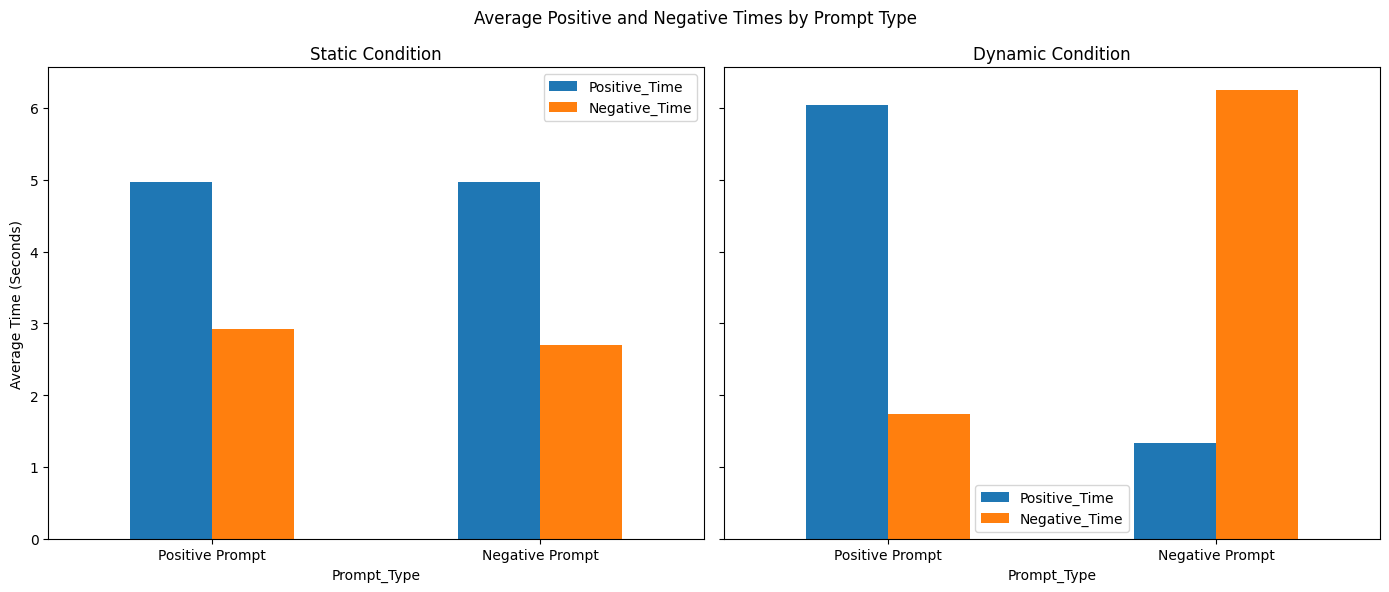

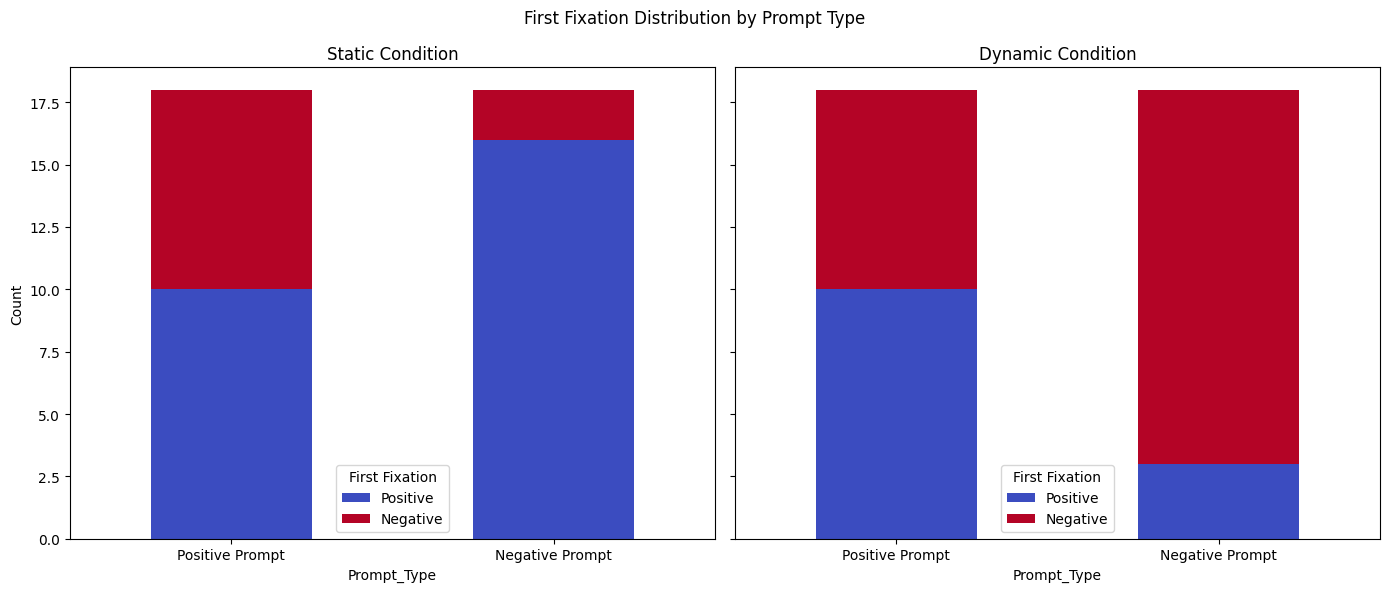

Key Metrics:
Static Positive Prompt Avg Positive Time: 4.96
Static Positive Prompt Avg Negative Time: 2.92
Static Negative Prompt Avg Positive Time: 4.98
Static Negative Prompt Avg Negative Time: 2.69
Dynamic Positive Prompt Avg Positive Time: 6.05
Dynamic Positive Prompt Avg Negative Time: 1.74
Dynamic Negative Prompt Avg Positive Time: 1.33
Dynamic Negative Prompt Avg Negative Time: 6.25


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

csv_file = "experiment_data.csv"  # Ensure this file exists
df = pd.read_csv(csv_file)

df["Prompt_Type"] = df["Group"].apply(lambda x: "Positive" if x <= 3 else "Negative")

static_data = df[df["Condition"] == "Static"]
dynamic_data = df[df["Condition"] == "Dynamic"]


static_avg_by_prompt = static_avg_by_prompt.reindex(["Positive", "Negative"])
dynamic_avg_by_prompt = dynamic_avg_by_prompt.reindex(["Positive", "Negative"])

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

static_avg_by_prompt.plot(kind="bar", ax=axes[0])
axes[0].set_title("Static Condition")
axes[0].set_ylabel("Average Time (Seconds)")
axes[0].set_xticklabels(["Positive Prompt", "Negative Prompt"], rotation=0)

# Dynamic Condition
dynamic_avg_by_prompt.plot(kind="bar", ax=axes[1])
axes[1].set_title("Dynamic Condition")
axes[1].set_xticklabels(["Positive Prompt", "Negative Prompt"], rotation=0)

plt.suptitle("Average Positive and Negative Times by Prompt Type")
plt.tight_layout()
plt.show()


static_fixation_distribution = (
    static_data.groupby(["Prompt_Type", "First_Fixation"])
    .size()
    .unstack(fill_value=0)
    .reindex(index=["Positive", "Negative"])  # Adjust Prompt_Type order
    .reindex(columns=["Positive", "Negative"], fill_value=0)  # Adjust First_Fixation order
)

dynamic_fixation_distribution = (
    dynamic_data.groupby(["Prompt_Type", "First_Fixation"])
    .size()
    .unstack(fill_value=0)
    .reindex(index=["Positive", "Negative"])  # Adjust Prompt_Type order
    .reindex(columns=["Positive", "Negative"], fill_value=0)  # Adjust First_Fixation order
)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

static_fixation_distribution.plot(kind="bar", stacked=True, ax=axes[0], colormap="coolwarm")
axes[0].set_title("Static Condition")
axes[0].set_ylabel("Count")
axes[0].set_xticklabels(["Positive Prompt", "Negative Prompt"], rotation=0)
axes[0].legend(title="First Fixation")

dynamic_fixation_distribution.plot(kind="bar", stacked=True, ax=axes[1], colormap="coolwarm")
axes[1].set_title("Dynamic Condition")
axes[1].set_xticklabels(["Positive Prompt", "Negative Prompt"], rotation=0)
axes[1].legend(title="First Fixation")

plt.suptitle("First Fixation Distribution by Prompt Type")
plt.tight_layout()
plt.show()

conclusion = {
    "Static Positive Prompt Avg Positive Time": static_avg_by_prompt.loc["Positive", "Positive_Time"],
    "Static Positive Prompt Avg Negative Time": static_avg_by_prompt.loc["Positive", "Negative_Time"],
    "Static Negative Prompt Avg Positive Time": static_avg_by_prompt.loc["Negative", "Positive_Time"],
    "Static Negative Prompt Avg Negative Time": static_avg_by_prompt.loc["Negative", "Negative_Time"],
    "Dynamic Positive Prompt Avg Positive Time": dynamic_avg_by_prompt.loc["Positive", "Positive_Time"],
    "Dynamic Positive Prompt Avg Negative Time": dynamic_avg_by_prompt.loc["Positive", "Negative_Time"],
    "Dynamic Negative Prompt Avg Positive Time": dynamic_avg_by_prompt.loc["Negative", "Positive_Time"],
    "Dynamic Negative Prompt Avg Negative Time": dynamic_avg_by_prompt.loc["Negative", "Negative_Time"],
}

print("Key Metrics:")
for key, value in conclusion.items():
    print(f"{key}: {value:.2f}")
